# Visualizing galaxy features related to gas mass fraction

Basically, the hard work was done by Quan Tran, who wrote an excellent [blog post](https://quantran.xyz/blog/building-an-image-classification-model-from-a-to-z/) and [demo notebook](https://nbviewer.jupyter.org/github/anhquan0412/animation-classification/blob/master/gradcam-usecase.ipynb) summarizing his [code on GradCAM + Guided Backpropagation](https://github.com/anhquan0412/animation-classification). The short of it is that classification problems in computer vision can be interpreted fairly readily, because the activations in the final layer determine which class is predicted. Thus, by highlighting those activations for any given input image, such as the validation data set, specific parts of the images can be linked to the output classes.

In this case, we use SDSS DR14 *gri* images crossmatched with the ALFALFA α.40 catalog. We set up the problem as a binary classification task, with low and high gas mass fractions $\log 
M_{\rm HI} / M_\star < -0.5$ and $> 0.5$ as the two classes.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from fastai import *
from fastai.vision import *

from glob import glob
import seaborn as sns

%matplotlib inline

%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

seed = 12345

/content/drive/My Drive/alfalfa-convnets


In [3]:
sys.path.append(f'{PATH}/src')

from mxresnet import *

from ranger import Ranger
from novograd import *
from ralamb import *
from over9000 import *
from lookahead import *

from fastai.callbacks import *

Mish activation loaded...
Mish activation loaded...


# GradCAM and Guided Backprop helper functions

All credit goes to @anhquan0412 on Github for this [incredibly useful code](https://github.com/anhquan0412/animation-classification/blob/master/gradcam.py). More discussion can be found on the [Fastai forums]((https://forums.fast.ai/t/gradcam-and-guided-backprop-intergration-in-fastai-library/33462) and another useful [notebook](https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam-dogs.ipynb) by @henripal on Github.

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label1= str(pred_class) if not label1 else label1
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        
        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        
        label2_args = None
        if label2:
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None):
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args
            
    def plot(self,plot_hm=True,plot_gbp=True):
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        # fig.savefig('data_draw/both/gradcam.png')

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "Mish"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.8, extent=(0,size,size,0),
              interpolation='bicubic',cmap='cividis');



#  Train binary classification problem (low and high gas mass fractions)

Here we will use the 18-layer mxresnet.

In [6]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')
df.logfgas = df.logfgas.round(1)

df['logfgas_cls'] = pd.cut(df.logfgas, [-2.5, -0.5, 0.5, 2.5], labels=['low', 'medium', 'high'])
df = df[df.logfgas_cls.isin(['low', 'high'])]
df.dropna(inplace=True)

df.sample(3)

,Unnamed: 0,AGCNr,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,logfgas_cls
3086,7909,230305,587738568710357048,9.40,10.580660,-0.103924,9.155517,-1.2,-10.684584,low
4252,10710,257899,587742061091881344,9.27,8.715098,-0.967478,8.356792,0.6,-9.682576,high
228,1169,180033,587742062119682294,9.87,10.497960,0.359010,9.129309,-0.6,-10.138950,low


In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

bs = 64
sz = 224

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas_cls'])
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [10]:
data.c

2

In [0]:
learn = Learner(data, model=mxresnet18(), 
                opt_func=partial(Ranger),
                loss_func=nn.CrossEntropyLoss(),
                metrics=[accuracy],
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(512, data.c, bias=True).cuda()

In [12]:
# warmup/load into memory
# learn.fit_one_cycle(1, 1e-4, pct_start=1.)

epoch,train_loss,valid_loss,accuracy,time
0,0.728060,0.700151,0.308605,08:26


In [48]:
learn.fit_one_cycle(30, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.668033,0.682421,0.474777,00:23
1,0.576322,0.564588,0.896142,00:18
2,0.461919,0.274155,0.949555,00:18
3,0.366304,0.187015,0.967359,00:18
4,0.292946,0.168030,0.949555,00:18
5,0.252527,0.191703,0.940653,00:18
6,0.214451,0.137861,0.973294,00:18
7,0.189443,0.110626,0.955490,00:18
8,0.164988,0.165106,0.940653,00:18
9,0.146098,0.295535,0.887240,00:18


In [49]:
# learn.save('mxresnet-18_gas-richness_30ep_for-saliency')
learn.load('mxresnet-18_gas-richness_30ep_for-saliency');

set state called


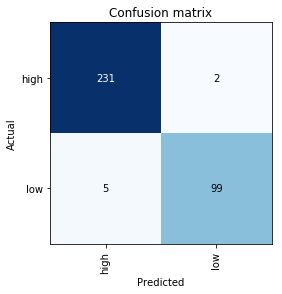

In [53]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

interp.plot_confusion_matrix()

# Visualization using GradCAM

Once again, all credit goes to @anhquan0412 on Github. Source code [here](https://github.com/anhquan0412/animation-classification/blob/master/gradcam.py).

In [0]:
# for (mx)resnet-18
def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[7][-1].convs[-1] # last layer of group 0                               # the layer group is worth playing around with
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


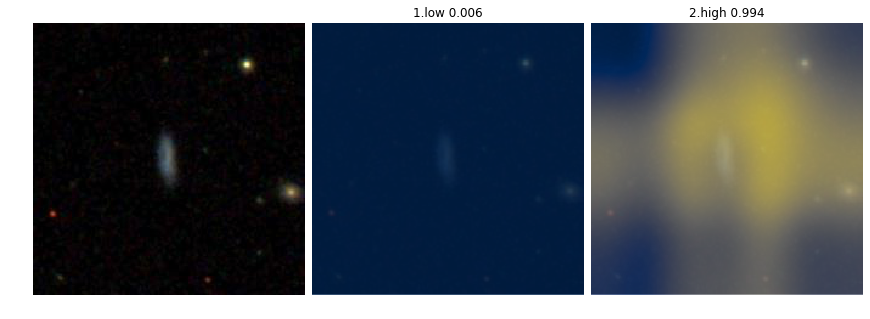

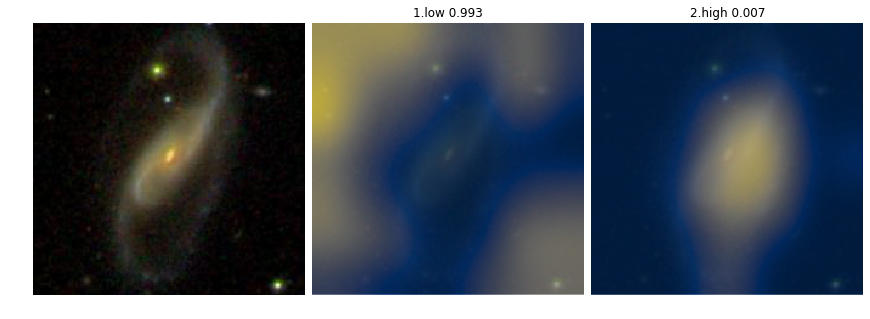

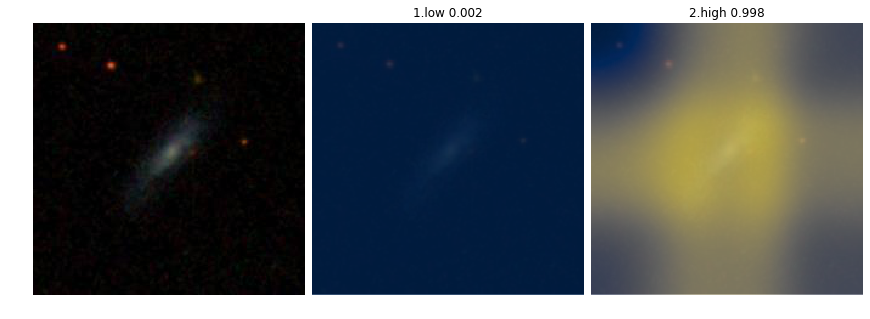

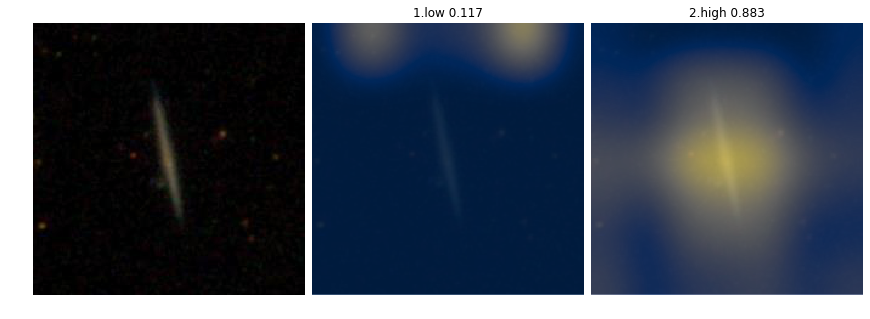

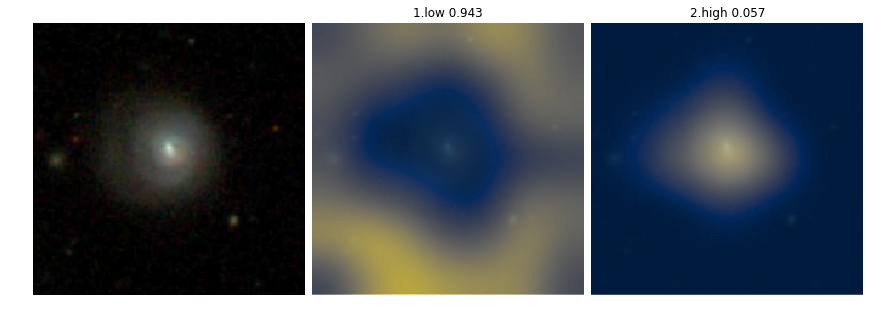

In [56]:
for fn in np.random.choice(data.valid_dl.items, size=5):
    img = open_image(fn);

    gcam = GradCam.from_one_img(learn, img, label1='low', label2='high')
    gcam.plot(plot_hm=True,plot_gbp=False)

## Repeat with a super simple convnet

The smaller convnet can be useful because, even though it's not too accurate all the time, it allows for higher resolution class activation maps

In [0]:

class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                 
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(128*16*16, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [0]:
learn = cnn_learner(data, base_arch=SimpleCNN,
                    opt_func=partial(Ranger),
                    loss_func=nn.CrossEntropyLoss(),
                    metrics=[accuracy]
                   )


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


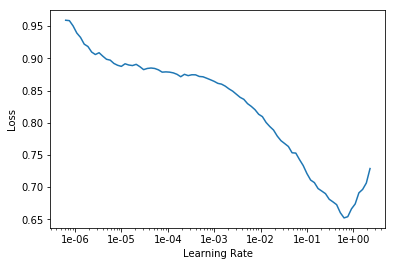

In [30]:
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(30, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.695406,0.708916,0.308605,00:15
1,0.573629,0.657485,0.620178,00:14
2,0.472477,0.383687,0.816024,00:14
3,0.389747,0.354165,0.863501,00:14
4,0.331292,0.316063,0.908012,00:14
5,0.302009,0.385521,0.893175,00:14
6,0.286740,0.386483,0.899110,00:14
7,0.280348,0.356117,0.928783,00:14
8,0.287645,0.443009,0.884273,00:14
9,0.269714,0.300017,0.931751,00:14


In [0]:
# for SimpleCNN
def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[-2][-1][-1] # last layer of group 0                               # the layer group is worth playing around with
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

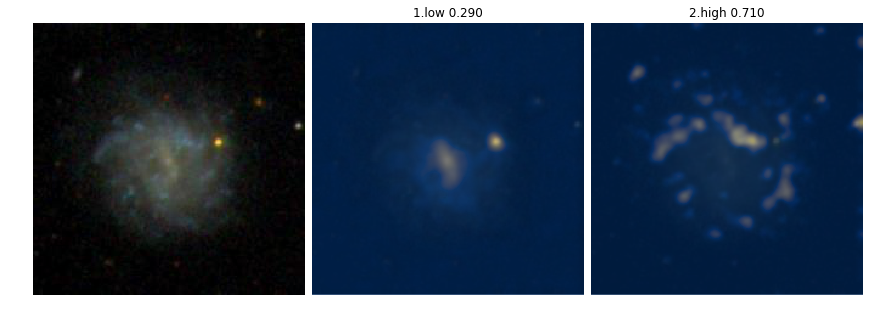

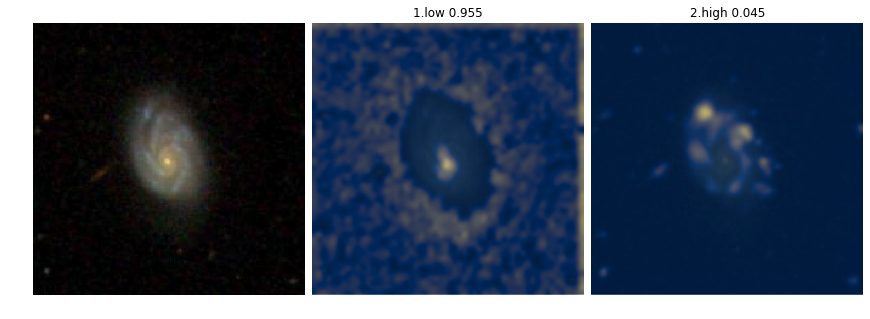

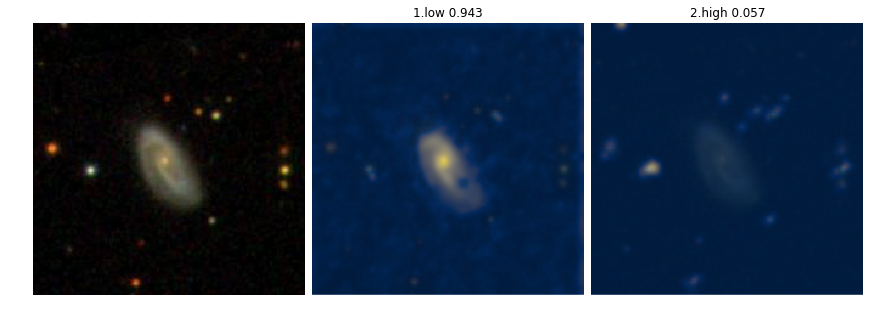

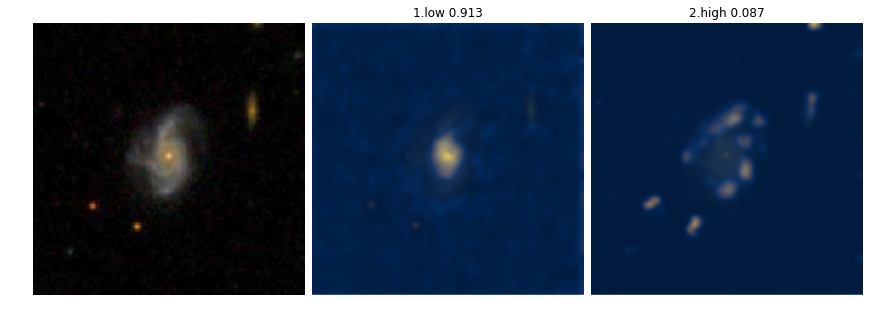

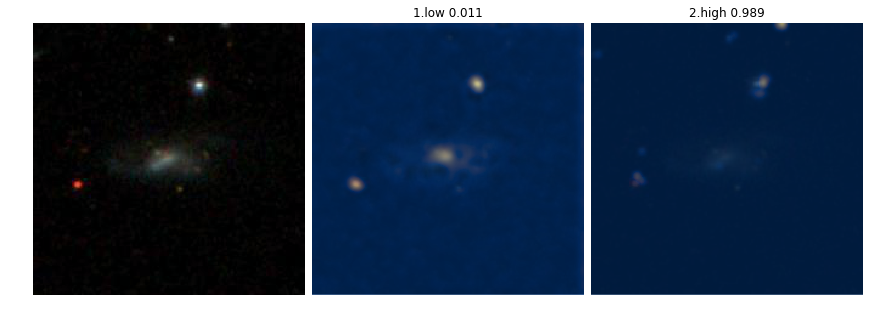

In [61]:
for fn in np.random.choice(data.valid_dl.items, size=5):
    img = open_image(fn);

    gcam = GradCam.from_one_img(learn, img, label1='low', label2='high')
    gcam.plot(plot_hm=True,plot_gbp=False)

Show all results!

In [63]:
len(data.valid_dl.items)

337

In [0]:
# turn off interactive plotting
%%capture

for fn in np.random.choice(data.valid_dl.items, size=len(data.valid_dl.items)):
    agcnr = os.path.basename(fn).strip('.jpg')
    img = open_image(fn);

    gcam = GradCam.from_one_img(learn, img, label1='low', label2='high')
    gcam.plot(plot_hm=True,plot_gbp=False)
    
    plt.savefig(f'{PATH}/results/gradcam/{agcnr}_binary-class.jpg')